# **RESULTADOS GENERALES - EQUIPO 9**
## ANÁLISIS DE NEGOCIO ENTIDAD FINANCIERA

    Grupo de Trabajo:
    - Roser Blasco - Analista de Perfil de Cliente
    - Raquel Limpo - Analista de Marketing y comunicación
    - Fabio Esparza - Analista de Marketing y Riesgo Crediticio
    - María Uriburu Gray - Analista de Marketing y Riesgo Crediticio

**Preguntas de Negocio Sprint 1:**
>- ¿Cuáles son los perfiles demográficos que muestran más propensión a contratar productos financieros?
>- ¿Qué relación hay entre el número de contactos realizados durante esta campaña y la tasa de éxito, y cómo podemos optimizar la frecuencia de contacto para maximizar los resultados de nuestras campañas de marketing?
>- ¿En qué medida los clientes con saldos más bajos están en mayor riesgo de incumplimiento de crédito, y cómo hemos de ajustar nuestras políticas de crédito para mitigar este riesgo?

### Carga de datos

In [26]:
"""Librerías que pueden ser necesarias"""

# Manejo de datos
import pandas as pd                 # Análisis y manipulación de datos en tablas
import numpy as np                  # Cálculos numéricos y matrices
import os                           # Gestión de rutas de archivos

# Visualización de datos
import matplotlib.pyplot as plt     # Gráficos básicos en 2D
import seaborn as sns               # Gráficos estadísticos mejorados
import plotly.express as px         # Gráficos interactivos simplificados
import plotly.graph_objects as go   # Control avanzado de gráficos en Plotly
import plotly.io as pio             # Interfaz de entrada/salida de Plotly
import squarify                     # Visualización de diagramas de "treemap"
from plottable import Table         # Visualización de tablas
import matplotlib.colors as mcolors # Colores y mapas de colores

# Procesado y análisis
from scipy import stats
from scipy.stats import mannwhitneyu

#Paleta de colores oficial
custom_palette = ["#2E2F36", "#5F6F81", "#AABBC8", "#DCE3EA", "#2CCED1"]

In [27]:
df = pd.read_csv("../Data/df.csv")

## Perfil de Cliente

Variables a analizar:
- Perfil demográfico
- Contratación del depósito

Preguntas a resolver:
- ¿Qué perfiles tengo? De lo general a lo particular, mostrar análisis univariados
- ¿Qué propensión tienen a contratar?

Primer estudiarem com afecten les variables demogràfiques a la contractació a nivell individual.

Després contrastarem dos perfils que intuitivament tenen sentit.

Finalment treurem les combinacions de variables amb més conversió per a crear perfils demogràfics objectiu.

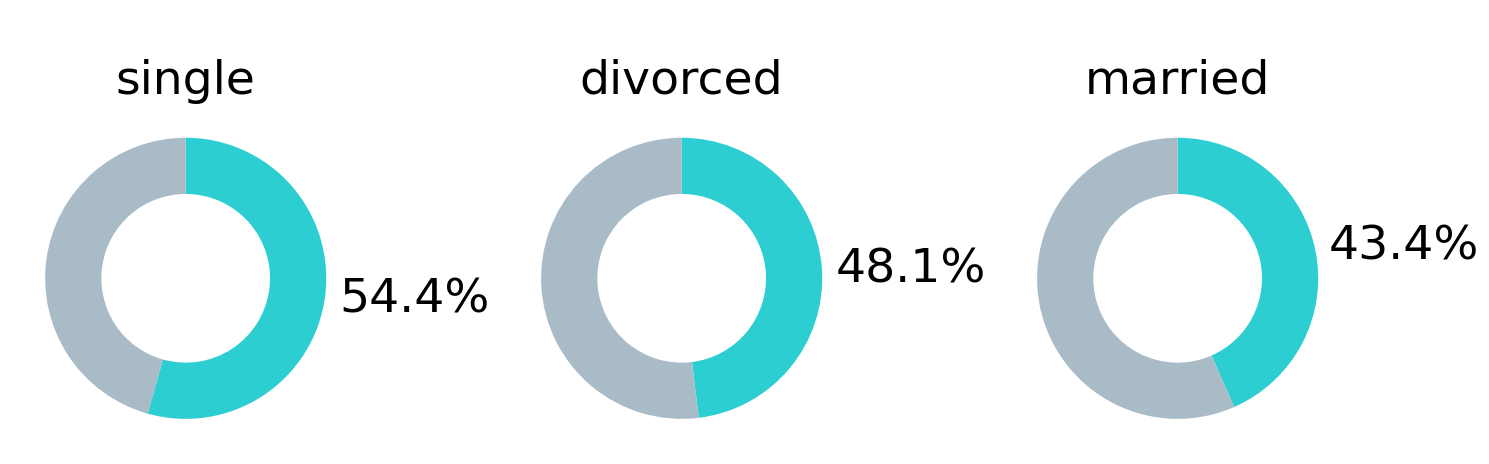

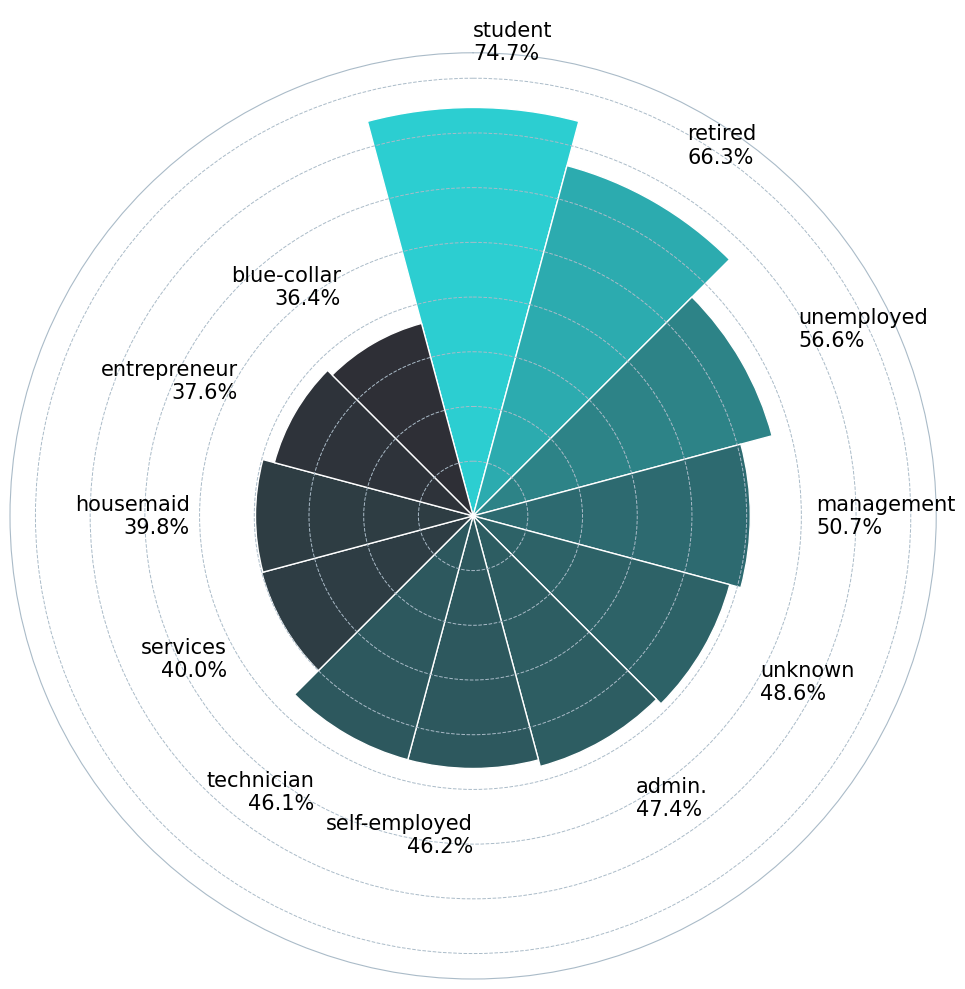

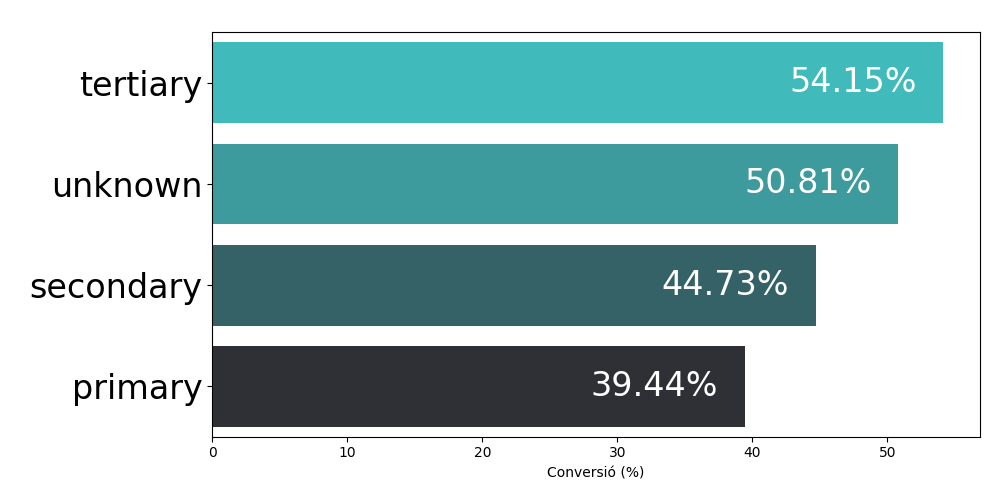

In [28]:
# ESTUDI INDIVIDUAL DE VARIABLES
# Colors personalitzats
colors = ['#2CCED1', '#AABBC8']

# Calcular percentatge de conversió per cada grup de marital
percentatges = []
for group in df['marital'].unique():
    subset = df[df['marital'] == group]
    conversio_counts = subset['deposit'].value_counts()
    conversions = conversio_counts.get(True, 0)
    no_conversions = conversio_counts.get(False, 0)
    total = conversions + no_conversions
    percent_converted = conversions / total * 100 if total > 0 else 0
    percentatges.append((group, conversions, no_conversions, percent_converted))

# Ordenar de més a menys percentatge de conversió
percentatges_ordenats = sorted(percentatges, key=lambda x: x[3], reverse=True)

# Crear figura amb 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, (group, conversions, no_conversions, percent_converted) in enumerate(percentatges_ordenats):
    # Etiquetes: només percentatge de conversió
    labels = [
        f'{percent_converted:.1f}%',  # Només percentatge "Contracta"
        ''                             # Cap text per "No contracta"
    ]

    # Donut plot
    axs[i].pie(
        [conversions, no_conversions],
        labels=labels,
        colors=colors,
        startangle=90,
        counterclock=False,
        wedgeprops=dict(width=0.4),
        textprops={'fontsize': 34, 'color': 'black'}
    )
    axs[i].set_title(f'{group}', fontsize=34)

plt.suptitle(' ', fontsize=16)
plt.tight_layout()
plt.show()

# Calcular percentatge de conversió per job
totals_per_job = df.groupby('job').id.count()
conversions_per_job = df[df['deposit'] == True].groupby('job').id.count()
percentatge_conversio = (conversions_per_job / totals_per_job * 100).sort_values(ascending=False)

# Crear DataFrame per visualització
df_percentatge = percentatge_conversio.reset_index()
df_percentatge.columns = ['job', 'percentatge_conversio']

# Ordenar de més a menys conversió
df_percentatge = df_percentatge.sort_values(by='percentatge_conversio', ascending=False).reset_index(drop=True)

# Paleta de colors (de fosc a turquesa)
norm = plt.Normalize(df_percentatge['percentatge_conversio'].min(), df_percentatge['percentatge_conversio'].max())
cmap = mcolors.LinearSegmentedColormap.from_list("custom", ["#2E2F36", "#2CCED1"])
colors = [cmap(norm(v)) for v in df_percentatge['percentatge_conversio']]

# Paràmetres per al gràfic circular
N = len(df_percentatge)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
values = df_percentatge['percentatge_conversio'].tolist()
labels = df_percentatge['job'].tolist()

# Ajustar angles per centrar les barres
angles += angles[:1]
values += values[:1]
colors += colors[:1]
labels += labels[:1]

# Crear gràfic
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'polar': True})

bars = ax.bar(
    angles[:-1], values[:-1], width=2*np.pi/N, color=colors[:-1], edgecolor='white', linewidth=1
)

# Afegir etiquetes
for angle, value, label in zip(angles[:-1], values[:-1], labels[:-1]):
    rotation = np.degrees(angle)
    alignment = 'left' if rotation < 180 else 'right'
    ax.text(
        angle,
        value + 12,  # una mica per sobre la barra
        f"{label}\n{value:.1f}%",
        ha=alignment,
        va='center',
        rotation=0,
        rotation_mode='anchor',
        fontsize=15,
        color='black'
    )

# Canviar el color dels cercles de fons (gridlines)
ax.grid(color='#AABBC8', linestyle='--', linewidth=0.7)

# Canviar el color del cercle exterior (spine)
ax.spines['polar'].set_color('#AABBC8')


# Estètica
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_ylim(0, max(values) + 10)
ax.set_yticklabels([])
ax.set_xticks([])

plt.title(' ', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Calcular percentatge de conversió per education
totals_per_education = df.groupby('education').id.count()
conversions_per_education = df[df['deposit'] == True].groupby('education').id.count()
percentatge_conversio = (conversions_per_education / totals_per_education * 100).sort_values(ascending=False)

# Crear DataFrame per visualització
df_percentatge = percentatge_conversio.reset_index()
df_percentatge.columns = ['education', 'percentatge_conversio']

# No fem cap filtrat, utilitzem tot el dataframe
df_filtrat = df_percentatge

# Crear paleta de colors personalitzada (de fosc a turquesa)
norm = plt.Normalize(df_filtrat['percentatge_conversio'].min(),
                     df_filtrat['percentatge_conversio'].max())
cmap = mcolors.LinearSegmentedColormap.from_list("custom", ["#2E2F36", "#2CCED1"])
bar_colors = [cmap(norm(v)) for v in df_filtrat['percentatge_conversio']]

# Crear el gràfic horitzontal amb hue per evitar warning
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=df_filtrat,
    y='education',
    x='percentatge_conversio',
    hue='education',
    palette=bar_colors,
    dodge=False,
    legend=False
)



# Augmentar mida de les etiquetes de l’eix y
ax.tick_params(axis='y', labelsize=24)

# Afegir etiquetes de percentatge DINS les barres
for i, row in df_filtrat.iterrows():
    ax.text(
        row['percentatge_conversio'] - 2,
        i,
        f"{row['percentatge_conversio']:.2f}%",
        va='center',
        ha='right',
        fontsize=24,
        color='white'
    )



# Estètica
plt.xlabel('Conversió (%)')
plt.ylabel(' ')
plt.title(' ')
plt.tight_layout()
plt.show()


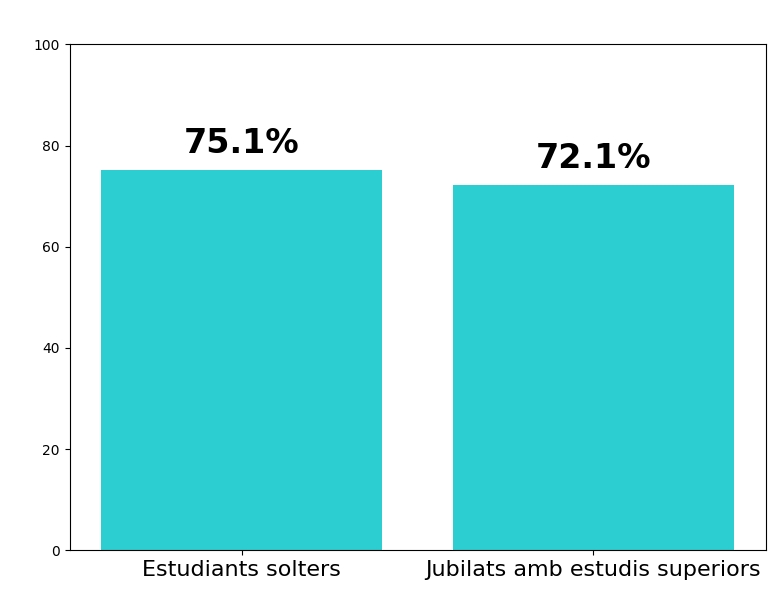

In [29]:
# CONTRAST DOS PERFILS 

# Perfil demogràfic: Estudiants solters
estudiants_solters = df[(df['job'] == 'student') & (df['marital'] == 'single')]
total_es = estudiants_solters.nunique().id
suscribieron_es = estudiants_solters[estudiants_solters['deposit'] == True].nunique().id
kpi1_es = suscribieron_es / total_es if total_es != 0 else 0

# Perfil demogràfic: Jubilats amb estudis superiors
jubilats_superiors = df[(df['job'] == 'retired') & (df['education'] == 'tertiary')]
total_js = jubilats_superiors.nunique().id
suscribieron_js = jubilats_superiors[jubilats_superiors['deposit'] == True].nunique().id
kpi1_js = suscribieron_js / total_js if total_js != 0 else 0

# Labels i valors
categories = ['Estudiants solters', 'Jubilats amb estudis superiors']
valors = [kpi1_es * 100, kpi1_js * 100]
colors = ['#2CCED1', '#2CCED1']

# Crear gràfic
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(categories, valors, color=colors)

# Afegir percentatges a sobre de les barres
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 2,
        f"{height:.1f}%",
        ha='center',
        va='bottom',
        fontsize=24,
        fontweight='bold'
    )

# Estètica
ax.set_ylim(0, 100)
ax.set_ylabel(' ', fontsize=12)
ax.set_title(' ', fontsize=24)
ax.tick_params(axis='x', labelsize=16)
plt.tight_layout()
plt.show()

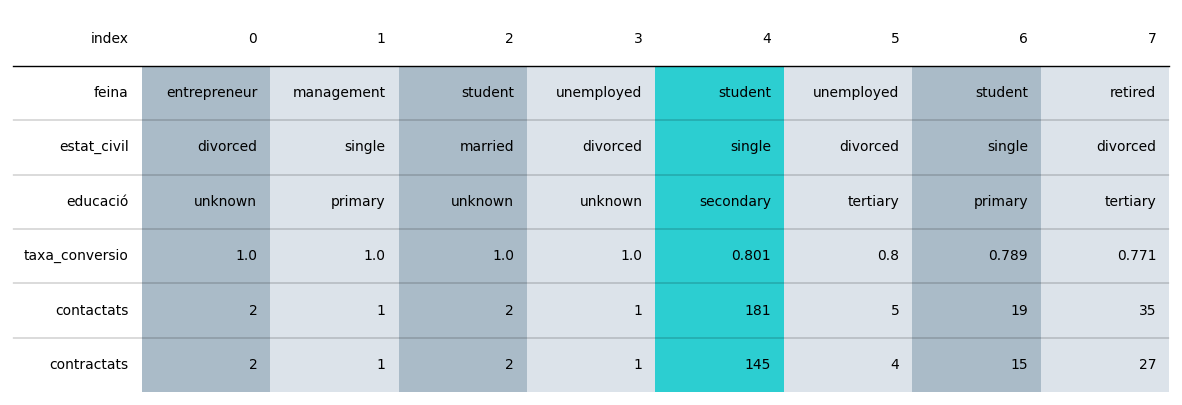

In [30]:
# TOP PERFILS
# Agrupem el dataframe per la combinació de les característiques demogràfiques 
df_agrupat_pc = df.groupby(['job', 'marital', 'education'])


# Creem una taula per al càlcul de conversions
taula_conversio_pc = []

# Recorrem la taula calculant la conversió de cada grup
for (feina, estat_civil, educacio), grup in df_agrupat_pc:
    contactats = grup.nunique().id
    contractats = grup[grup['deposit'] == True].nunique().id
    conversio = contractats / contactats if contactats != 0 else 0

    # Afegim cada resultat a la taula
    taula_conversio_pc.append({
        'feina': feina,
        'estat_civil': estat_civil,
        'educació': educacio,
        'contactats': contactats,
        'contractats': contractats,
        'taxa_conversio': conversio
    })

# Convertim la taula de conversió en un dataframe 
df_conversio_pc = pd.DataFrame(taula_conversio_pc)

# Ordenem el dataframe per la taxa de conversió de major a menor
resultats_ordenats = df_conversio_pc.sort_values(by='taxa_conversio', ascending=False)

# Arrodonim la taxa de conversió a 3 decimals
resultats_ordenats['taxa_conversio'] = resultats_ordenats['taxa_conversio'].round(3)

# Reiniciem l'index
resultats_ordenats = resultats_ordenats.reset_index()
resultats_ordenats = resultats_ordenats.drop(columns=['index'])

# Fer còpia del top 8 i seleccionar columnes
top8_resultats_ordenats = resultats_ordenats.head(8).copy()
top8_resultats_ordenats = top8_resultats_ordenats[[
    'feina', 'estat_civil', 'educació', 'taxa_conversio', 'contactats', 'contractats'
]]


# Reordenar columnes si cal
top8_resultats_ordenats = top8_resultats_ordenats[[
    'feina', 'estat_civil', 'educació', 'taxa_conversio', 'contactats', 'contractats'
]]



# Transposar per visualització
top8_resultats_ordenats = top8_resultats_ordenats.transpose()

# Mostrar taula 
fig, ax = plt.subplots(figsize=(15, 5))
tab = Table(
    top8_resultats_ordenats,
)

# Modifiquem manualment els colors de les columnes
tab.columns[0].set_facecolor('#AABBC8')
tab.columns[1].set_facecolor('#DCE3EA')
tab.columns[2].set_facecolor('#AABBC8')
tab.columns[3].set_facecolor('#DCE3EA')
tab.columns[4].set_facecolor('#2CCED1')
tab.columns[5].set_facecolor('#DCE3EA')
tab.columns[6].set_facecolor('#AABBC8')
tab.columns[7].set_facecolor('#DCE3EA')


plt.show()

## Marketing y Comunicación

Variables a analizar:
- Número de contactos
- Tasa de éxito

Preguntas a resolver:
- ¿Cuál es la frecuencia del número de contactos?
- ¿Hay una tasa de éxito?

`Este análisis se realizó íntegramente en Power BI. Ver resultados en archivo ...`

## Finanzas y Riesgo Crediticio

Variables a analizar:
- Saldos -> balance
- Cumplimiento de crédito -> default

Preguntas a resolver:
- ¿Cómo varían los saldos de los clientes?
- ¿Cumplen o no con los créditos?

           count         mean          std     min    25%    50%     75%  \
default                                                                    
False    10973.0  1553.947690  3244.789130 -3058.0  132.0  564.0  1737.0   
True       168.0   -61.803571   827.742361 -6847.0 -344.0    0.0    65.5   

             max  
default           
False    81204.0  
True      5249.0  


<Axes: xlabel='balance', ylabel='Count'>

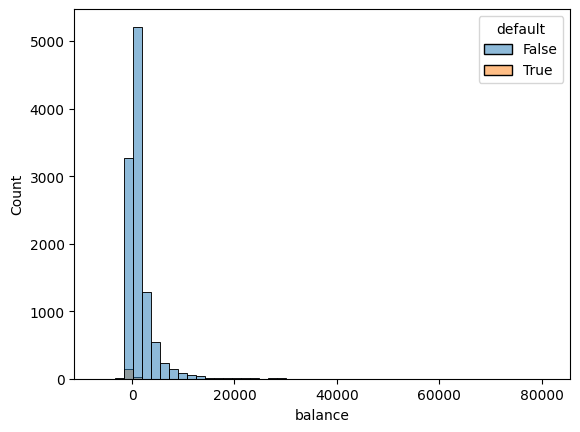

In [31]:
print(df.groupby('default')['balance'].describe())
sns.histplot(data=df, x='balance', hue='default', bins=50)

#### Para saber si son distribuciones normales --> Test de Shapiro-Wilk
- No son distribuciones normales

In [32]:
# Prueba de normalidad
    # Si p < 0.05 --> no es normal
saldo_incumplen = df[df['default'] == 1]['balance']
saldo_cumplen = df[df['default'] == 0]['balance']

stat_true, p_true = stats.shapiro(saldo_incumplen)
stat_false, p_false = stats.shapiro(saldo_cumplen)

print(f'Distribución de los que incumplen, Shapiro-Wilk: p={p_true}')  
print(f'Distribución de los que cumplen, Shapiro-Wilk: p={p_false}') 

Distribución de los que incumplen, Shapiro-Wilk: p=1.3038098569837037e-19
Distribución de los que cumplen, Shapiro-Wilk: p=8.010719219311176e-102


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10973.
  res = hypotest_fun_out(*samples, **kwds)


### Tasa de incumplimiento de la muestra por deciles

Tasa de incumplimiento por decil de saldo:
   balance_decile  default
0               1   0.0706
1               2   0.0284
2               3   0.0135
3               4   0.0089
4               5   0.0036
5               6   0.0027
6               7   0.0072
7               8   0.0009
8               9   0.0009
9              10   0.0009


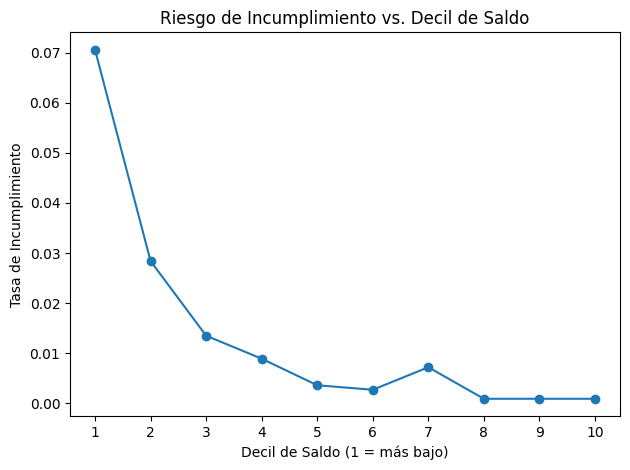

Decil 1: (-6847.001, 0.0]
Decil 2: (0.0, 62.0]
Decil 3: (62.0, 189.0]
Decil 4: (189.0, 337.0]
Decil 5: (337.0, 550.0]
Decil 6: (550.0, 863.0]
Decil 7: (863.0, 1341.0]
Decil 8: (1341.0, 2225.0]
Decil 9: (2225.0, 3899.0]
Decil 10: (3899.0, 81204.0]


In [33]:
df = pd.read_csv("../Data/df.csv")

#  Crear deciles de balance para agrupar clientes en 10 grupos iguales
df['balance_decile'] = pd.qcut(df['balance'], q=10, labels=False)

# Calcular la tasa de incumplimiento (default) por cada decil
default_rates = (df.groupby('balance_decile')['default'].mean().reset_index()) #la media aritmética en ese grupo equivale a la proporción (o tasa) de incumplimiento
default_rates['default'] = default_rates['default'].round(4) 
default_rates['balance_decile'] = default_rates['balance_decile'] + 1

#  Mostrar resultados en consola
print("Tasa de incumplimiento por decil de saldo:")
print(default_rates)

#  Graficar la relación
plt.figure()
plt.plot(default_rates['balance_decile'], default_rates['default'], marker='o')
plt.xlabel('Decil de Saldo (1 = más bajo)')
plt.ylabel('Tasa de Incumplimiento')
plt.title('Riesgo de Incumplimiento vs. Decil de Saldo')
plt.xticks(range(1, 11))
plt.tight_layout()
plt.show()

# Crear los bins explícitamente con qcut
df['balance_decile_range'] = pd.qcut(df['balance'], q=10)

# Obtener los intervalos únicos en orden
balance_ranges = df['balance_decile_range'].cat.categories

# Mostrar los rangos de cada decil
for i, r in enumerate(balance_ranges, start=1):
    print(f"Decil {i}: {r}")

In [34]:
# Calcular tasa global de incumplimiento
Tasa_global_impagos = df['default'].mean()
print(f"Tasa global de incumplimiento: {Tasa_global_impagos:.4f}")
# Calculamos el indice de riesgo por decil riesgo/riesgo global
default_rates['indice_riesgo'] = default_rates['default'] / Tasa_global_impagos
default_rates['indice_riesgo'] = default_rates['indice_riesgo'].round(2)
print(default_rates)

Tasa global de incumplimiento: 0.0151
   balance_decile  default  indice_riesgo
0               1   0.0706           4.68
1               2   0.0284           1.88
2               3   0.0135           0.90
3               4   0.0089           0.59
4               5   0.0036           0.24
5               6   0.0027           0.18
6               7   0.0072           0.48
7               8   0.0009           0.06
8               9   0.0009           0.06
9              10   0.0009           0.06


### Visualización completa incorporando un umbral de riesgo
**Fuente**: Elaboración propia basada en prácticas comunes del sector bancario para productos de crédito revolvente, con referencias a datos de morosidad publicados por el Federal Reserve Bank of New York y lineamientos de Basilea II/III para segmentación de riesgo retail.

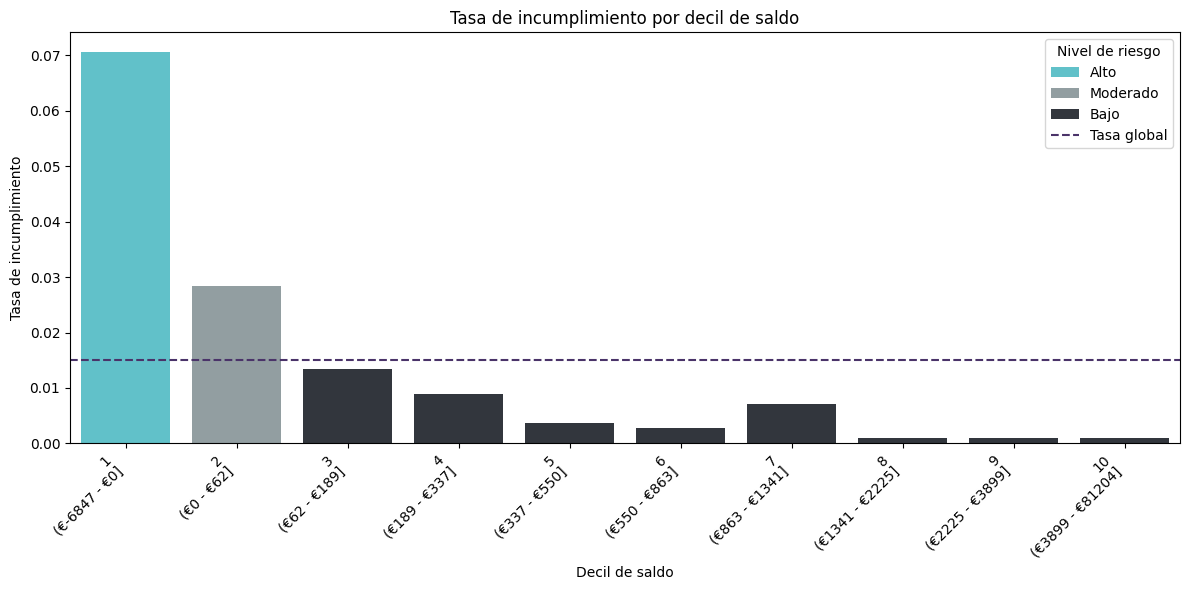

In [35]:
def categorize_risk(rate):
    if rate > 0.10:
        return 'Muy alto'
    elif rate > 0.05:
        return 'Alto'
    elif rate > 0.02:
        return 'Moderado'
    else:
        return 'Bajo'
    
#  Definir colores personalizados para cada nivel de riesgo
color_map = {
    'Muy alto': '#4A3369',     
    'Alto': '#4FD0DB',         
    'Moderado': '#8FA0A3',     
    'Bajo': '#30353F'          
}

# Crear una lista de etiquetas con número de decil y su rango
decile_labels = [
    f"{i+1}\n(€{int(interval.left)} - €{int(interval.right)}]"
    for i, interval in enumerate(balance_ranges)
]

default_rates['risk_level'] = default_rates['default'].apply(categorize_risk)
plt.figure(figsize=(12, 6))
sns.barplot(data=default_rates, x='balance_decile', y='default', hue='risk_level', palette=color_map)
plt.axhline(Tasa_global_impagos, color='#4A3369', linestyle='--', label='Tasa global')
plt.xticks(ticks=range(10), labels=decile_labels, rotation=45, ha='right')
plt.title('Tasa de incumplimiento por decil de saldo')
plt.xlabel('Decil de saldo')
plt.ylabel('Tasa de incumplimiento')
plt.legend(title='Nivel de riesgo')
plt.tight_layout()
plt.savefig('../Results/tasa_incumplimiento_deciles.png', dpi=300)
plt.show()

#### Test estadístico para comprobación de hipótisis

### ¿Qué hace este test de Mann-Whitney U?
###### Útil para muestras que no siguen distribuciones normales y es robusto ante valores aatípicos

Evalúa la hipótesis nula (H₀):

> Las dos muestras (saldo\_incumplen y saldo\_cumplen) provienen de la misma distribución (no hay diferencias en la tendencia central).

Contra la hipótesis alternativa (H₁):

> Las distribuciones son diferentes (una tiende a tener valores más altos o más bajos que la otra).

Resultado del test:

- U_stat: estadístico U, que mide cuántos valores de un grupo “superan” a los del otro en rango.

- p_val: valor-p, que nos dice la probabilidad de observar una diferencia en los rangos tan grande como la obtenida (o mayor) si las dos distribuciones fueran realmente iguales.


Este test no compara medias, sino **rangos**.
Es ideal cuando los datos están sesgados, tienen outliers o no son normales

In [36]:
# Aplicar la prueba de Mann-Whitney
stat, p = mannwhitneyu(saldo_incumplen, saldo_cumplen, alternative='two-sided')

print(f'Estadístico U: {stat}')
print(f'Valor p: {p}')

"""Como el valor p es extremadamente pequeño, rechazamos la hipótesis nula (H₀).
Esto indica que las distribuciones de saldo entre los que incumplen y los que no incumplen son significativamente diferentes.

Los clientes que incumplen tienden a tener saldos sistemáticamente más bajos que los que no incumplen.
Y esta diferencia no se debe al azar.

Analizamos los saldos disponibles de los clientes que cumplen con sus créditos y los que no. Queríamos saber si hay una diferencia real entre ambos grupos, o si lo que vemos es simplemente casualidad.

Usamos una prueba estadística diseñada para este tipo de situaciones, especialmente cuando los datos no se comportan de forma regular (es decir, no siguen una forma simétrica ni “normal”).

La diferencia entre los dos grupos es extremadamente significativa.
Los clientes que incumplen tienden a tener saldos mucho más bajos que los que sí cumplen, y esta diferencia no es por azar ni por coincidencia."""

Estadístico U: 276024.5
Valor p: 6.2344078260816756e-55


'Como el valor p es extremadamente pequeño, rechazamos la hipótesis nula (H₀).\nEsto indica que las distribuciones de saldo entre los que incumplen y los que no incumplen son significativamente diferentes.\n\nLos clientes que incumplen tienden a tener saldos sistemáticamente más bajos que los que no incumplen.\nY esta diferencia no se debe al azar.\n\nAnalizamos los saldos disponibles de los clientes que cumplen con sus créditos y los que no. Queríamos saber si hay una diferencia real entre ambos grupos, o si lo que vemos es simplemente casualidad.\n\nUsamos una prueba estadística diseñada para este tipo de situaciones, especialmente cuando los datos no se comportan de forma regular (es decir, no siguen una forma simétrica ni “normal”).\n\nLa diferencia entre los dos grupos es extremadamente significativa.\nLos clientes que incumplen tienden a tener saldos mucho más bajos que los que sí cumplen, y esta diferencia no es por azar ni por coincidencia.'

**Preguntas**

1. ¿Hay evidencia clara de que el riesgo de incumplimiento es más alto con saldos bajos?

2. ¿Cómo varía el riesgo entre los diferentes deciles?

3. ¿La diferencia es estadísticamente significativa?

**Resultados**
- El valor-p es muchísimo menor que 0.05 (p = 6.23e-55), lo que nos permite rechazar la hipótesis nula con total seguridad.
- El estadístico U fue de 276024.5, lo cual, junto con el valor-p, indica que las distribuciones de saldo entre clientes que incumplen y los que no, son significativamente diferentes.
- La mediana del saldo de los clientes que incumplen es claramente más baja, lo que refuerza la idea de que hay una asociación entre bajo saldo y mayor riesgo de impago.
*Sí, los clientes con saldos más bajos tienden a incumplir más el crédito*

**Respuestas**
1. Sí, existe evidencia clara. La prueba de Mann-Whitney U dio un estadístico U = 276024.5 con un p-valor extremadamente bajo, p-valor < 0.000001, lo que indica que la diferencia entre las distribuciones de saldo es significativa. Esto sugiere que los clientes que incumplen tienden a tener saldos más bajos.

2. Variación del riesgo entre deciles:
    - El riesgo disminuye a medida que aumenta el decil de saldo.
    - Los 3 primeros deciles (saldos más bajos) concentran la mayoría de los incumplimientos.
    - A partir del decil 5 la tasa de riesgo es mínima (< 0.3 %)

3. Sí, la diferencia es estadísticamente significativa. Aunque el test de Mann-Whitney no compara medias sino rangos y distribuciones, el resultado confirma que los saldos de quienes incumplen tienden a ser más bajos que los de quienes cumplen.